In [4]:
# Use DeepSurv from the repo
import lasagne
from deepsurv import deep_surv, utils, datasets

from deepsurv.deepsurv_logger import DeepSurvLogger, TensorboardLogger
from deepsurv import viz
import deepsurv

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from lifelines import CoxPHFitter
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from bayes_opt import bayesian_optimization
import optunity

In [14]:
import h5py
filename = 'C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/whas_train_test.h5'
f = h5py.File(filename, 'r')

#Get the HDF5 group
group = f['train']

#Checkout what keys are inside that group.
for key in group.keys():
    print(key)

data_x = group['x'].value
data_t = group['t'].value
data_e = group['e'].value

#Do whatever you want with data

#After you are done
f.close()

train_df = pd.DataFrame(data_x)
train_df['Time'] = np.int32(data_t)
train_df['Event'] = data_e

e
t
x


C:\Users\ASUS\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [15]:
train_df, val_df = train_test_split(train_df, test_size = 0.2)

In [16]:
# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'Event', time_col = 'Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_df, event_col = 'Event', time_col= 'Time')
val_data = dataframe_to_deepsurv_ds(val_df, event_col = 'Event', time_col = 'Time')

In [23]:
#Hyperparameter tunning
def get_optimizer_from_str(update_fn):
    if update_fn == 'sgd':
        return lasagne.updates.sgd
    elif update_fn == 'adam':
        return lasagne.updates.adam
    elif update_fn == 'rmsprop':
        return lasagne.updates.rmsprop

    return None

def get_objective_function(num_epochs):

    def format_to_deepsurv(x, y):
        return {
            'x': x,
            'e': y[:,0].astype(np.int32),
            't': y[:,1].astype(np.float32)
        }

    def get_hyperparams(params):
        hyperparams = {
            'batch_norm': False,
            'activation': 'selu',
            'standardize': True
        }
        # @TODO add default parameters and only take necessary args from params
        # protect from params including some other key

        if 'num_layers' in params and 'num_nodes' in params:
            params['hidden_layers_sizes'] = [int(params['num_nodes'])] * int(params['num_layers'])
            del params['num_layers']
            del params['num_nodes']

        if 'learning_rate' in params:
            params['learning_rate'] = 10 ** params['learning_rate']

        hyperparams.update(params)
        return hyperparams

    def train_deepsurv(x_train, y_train, x_test, y_test,
        **kwargs):
        # Standardize the datasets
        train_mean = x_train.mean(axis = 0)
        train_std = x_train.std(axis = 0)

        x_train = (x_train - train_mean) / train_std
        x_test = (x_test - train_mean) / train_std

        train_data = format_to_deepsurv(x_train, y_train)
        valid_data = format_to_deepsurv(x_test, y_test)

        hyperparams = get_hyperparams(kwargs)

        network = deep_surv.DeepSurv(n_in=x_train.shape[1], **hyperparams)
        metrics = network.train(train_data, n_epochs = num_epochs,
            update_fn = lasagne.updates.nesterov_momentum, verbose = False)

        result = network.get_concordance_index(**valid_data)
        return result

    return train_deepsurv



if __name__ == '__main__':

    NUM_EPOCHS = 500
    NUM_FOLDS = 10

    x = train_data['x']
    e = train_data['e']
    
    t = train_data['t']
    y = np.column_stack((e, t))
    
    

    opt_fxn = get_objective_function(NUM_EPOCHS)
    opt_fxn = optunity.cross_validated(x=x, y=y, num_folds=NUM_FOLDS,
        strata=False)(opt_fxn)

    opt_params, _, _ = optunity.maximize(opt_fxn, num_evals=200,
        learning_rate =[-7,-3], lr_decay = [0.0, 0.001], momentum = [0.8, 0.95], L2_reg = [0.05, 5.0], dropout = [0.0, 0.5])

In [24]:
opt_params

{'learning_rate': -3.909951291767589,
 'lr_decay': 0.0004735351562499999,
 'momentum': 0.8905769329901524,
 'L2_reg': 3.1215680425516608,
 'dropout': 0.316669921875}

In [1]:
hyperparams = {
    "L2_reg": 2.8032470703125, 
    "dropout": 0.0899951171875, 
    "learning_rate": 0.023825980458515722, 
    "lr_decay": 0.0005817382812499998, 
    "momentum": 0.8383100585937501, 
    "batch_norm": True, 
    "standardize": True, 
    "n_in": 6, 
    "hidden_layers_sizes": [120,120,120]
}


In [5]:
hyperparams = {
"learning_rate": 0.023094096518941305, 
 "dropout": 0.017243652343750002, 
 "lr_decay": 0.0009819482421875, 
 "momentum": 0.926554443359375, 
 "L2_reg": 2.364680908203125, 
 "batch_norm": True, 
 "standardize": True, 
 "n_in": 6, 
 "hidden_layers_sizes": [26, 26, 26],
 "activation": "selu"}


In [64]:
hyperparams = {
    "L2_reg": 3.1215680425516608, 
    "dropout": 0.316669921875, 
    "learning_rate": 0.023825980458515722, 
    "lr_decay": 0.0004735351562499999, 
    "momentum": 0.8905769329901524, 
    "batch_norm": True, 
    "standardize": True, 
    "n_in": 5, 
    "hidden_layers_sizes": [120, 120, 120]
}

In [13]:
# Create an instance of DeepSurv using the hyperparams defined above
model = deep_surv.DeepSurv(**hyperparams)

# DeepSurv can now leverage TensorBoard to monitor training and validation
# This section of code is optional. If you don't want to use the tensorboard logger
# Uncomment the below line, and comment out the other three lines: 
# logger = None

experiment_name = 'test_experiment_sebastian'
logdir = './logs/tensorboard/'
logger = TensorboardLogger(experiment_name, logdir=logdir)

# Now we train the model
update_fn=lasagne.updates.adam # The type of optimizer to use. \
                                            # Check out http://lasagne.readthedocs.io/en/latest/modules/updates.html \
                                            # for other optimizers to use
        
n_epochs = 1200

# If you have validation data, you can add it as the second parameter to the function
metrics = model.train(train_data, val_data, validation_frequency = 100, n_epochs = n_epochs, logger=logger, update_fn=update_fn)

ValueError: shapes (1236,7) and (5,26) not aligned: 7 (dim 1) != 5 (dim 0)
Apply node that caused the error: dot(x, W)
Toposort index: 13
Inputs types: [TensorType(float32, matrix), TensorType(float64, matrix)]
Inputs shapes: [(1236, 7), (5, 26)]
Inputs strides: [(28, 4), (208, 8)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Sum{axis=[0], acc_dtype=float64}(dot.0), Elemwise{sub,no_inplace}(dot.0, InplaceDimShuffle{x,0}.0), Elemwise{Sub}[(0, 0)](dot.0, mean)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "<ipython-input-13-d947fa66cf27>", line 21, in <module>
    metrics = model.train(train_data, val_data, validation_frequency = 100, n_epochs = n_epochs, logger=logger, update_fn=update_fn)
  File "C:\Users\ASUS\Anaconda3\lib\site-packages\deepsurv\deep_surv.py", line 396, in train
    update_fn = update_fn, **kwargs
  File "C:\Users\ASUS\Anaconda3\lib\site-packages\deepsurv\deep_surv.py", line 243, in _get_train_valid_fn
    learning_rate=learning_rate, **kwargs
  File "C:\Users\ASUS\Anaconda3\lib\site-packages\deepsurv\deep_surv.py", line 192, in _get_loss_updates
    + regularize_layer_params(self.network, l2) * L2_reg
  File "C:\Users\ASUS\Anaconda3\lib\site-packages\deepsurv\deep_surv.py", line 155, in _negative_log_likelihood
    risk = self.risk(deterministic)
  File "C:\Users\ASUS\Anaconda3\lib\site-packages\deepsurv\deep_surv.py", line 541, in risk
    deterministic = deterministic)
  File "C:\Users\ASUS\Anaconda3\lib\site-packages\lasagne\layers\helper.py", line 197, in get_output
    all_outputs[layer] = layer.get_output_for(layer_inputs, **kwargs)
  File "C:\Users\ASUS\Anaconda3\lib\site-packages\lasagne\layers\dense.py", line 121, in get_output_for
    activation = T.dot(input, self.W)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

    "L2_reg": 2.8032470703125, 
    "dropout": 0.0899951171875, 
    "learning_rate": 0.023825980458515722, 
    "lr_decay": 0.0005817382812499998, 
    "momentum": 0.8383100585937501, 
        
    "learning_rate": [-7,-3],
    "lr_decay": [0.0, 0.001],
    "momentum": [0.8, 0.95],
    "L2_reg": [0.05, 5.0],
    "dropout": [0.0, 0.5]

Train C-Index: (1199, 0.9213210328003321)
Validation C-index :  (1100, 0.8257427950275935)


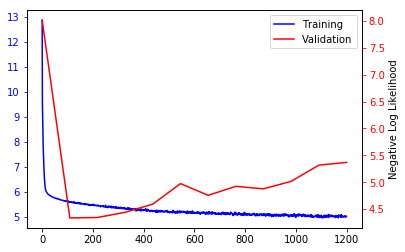

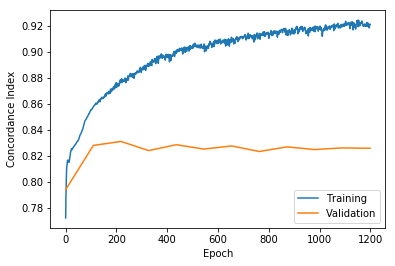

In [109]:
# Print the final metrics
print('Train C-Index:', metrics['c-index'][-1])
print('Validation C-index : ', metrics['valid_c-index'][-1])

# Plot the training / validation curves
viz.plot_log(metrics)

In [81]:
#test 데이터 불러오기
filename = 'C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/whas_train_test.h5'
f = h5py.File(filename, 'r')

#Get the HDF5 group
group = f['test']

#Checkout what keys are inside that group.
for key in group.keys():
    print(key)

test_x = group['x'].value
test_t = group['t'].value
test_e = group['e'].value

#Do whatever you want with data

#After you are done
f.close()

test_df = pd.DataFrame(data_x)
test_df['Time'] = np.int32(data_t)
test_df['Event'] = data_e

#test_df = test_df.drop(0, axis = 1)

test_data = dataframe_to_deepsurv_ds(test_df, event_col = 'Event', time_col= 'Time')

e
t
x


C:\Users\ASUS\Anaconda3\lib\site-packages\h5py\_hl\dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


In [8]:
import argparse
from collections import defaultdict
import uuid
import copy
import json
import time
import pylab
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
localtime   = time.localtime()
TIMESTRING  = time.strftime("%m%d%Y%M", localtime)

def evaluate_model(model, dataset, bootstrap = False):

    metrics = {}

    # Calculate c_index
    metrics['c_index'] = model.get_concordance_index(**dataset)
    if bootstrap:
        metrics['c_index_bootstrap'] = utils.bootstrap_metric(model.get_concordance_index, dataset)
    

    return metrics

def plot_survival_curves(rec_t, rec_e, antirec_t, antirec_e, experiment_name = '', output_file = None):
    # Set-up plots
    plt.figure(figsize=(12,3))
    ax = plt.subplot(111)

    # Fit survival curves
    kmf = KaplanMeierFitter()
    kmf.fit(rec_t, event_observed=rec_e, label=' '.join([experiment_name, "Treatment"]))   
    kmf.plot(ax=ax,linestyle="-")
    kmf.fit(antirec_t, event_observed=antirec_e, label=' '.join([experiment_name, "Non-treatment"]))
    kmf.plot(ax=ax,linestyle="--")
    
    # Format graph
    plt.ylim(0,1);
    ax.set_xlabel('Timeline (months)',fontsize='large')
    ax.set_ylabel('Percentage of Population Alive',fontsize='large')
    
    # Calculate p-value
    results = logrank_test(rec_t, antirec_t, rec_e, antirec_e, alpha=.95)
    results.print_summary()

    # Location the label at the 1st out of 9 tick marks
    xloc = max(np.max(rec_t),np.max(antirec_t)) / 9
    plt.legend(loc='best',prop={'size':15})
    print('p-value : ',results.p_value)


    if output_file:
        plt.tight_layout()
        pylab.savefig(output_file)
        
        

def save_treatment_rec_visualizations(model, dataset, output_dir, 
    trt_i = 1, trt_j = 0, trt_idx = 0):
    
    trt_values = np.unique(dataset['x'][:,trt_idx])
    print("Recommending treatments:", trt_values)
    rec_trt = model.recommend_treatment(dataset['x'], trt_i, trt_j, trt_idx)
    rec_trt = np.squeeze((rec_trt < 0).astype(np.int32))

    rec_dict = utils.calculate_recs_and_antirecs(rec_trt, true_trt = trt_idx, dataset = dataset)
    
    output_file = output_dir + 'trt_plot.pdf'
    print(output_file)
    plot_survival_curves(experiment_name = '', output_file=output_file, **rec_dict)

# WHAS

In [3]:
hyperparams = {
"learning_rate": 0.023094096518941305, 
 "dropout": 0.017243652343750002, 
 "lr_decay": 0.0009819482421875, 
 "momentum": 0.926554443359375, 
 "L2_reg": 2.364680908203125, 
 "batch_norm": True, 
 "standardize": True, 
 "n_in": 6, 
 "hidden_layers_sizes": [26, 26, 26],
 "activation": "selu"}




if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/whas_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = deep_surv.DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 1200,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.9129667670136854}
Test metrics: {'c_index': 0.8655161953554215, 'c_index_bootstrap': {'mean': 0.8679675000477424, 'confidence_interval': (0.8649107638030836, 0.8710242362924011)}}


# GBSG

In [11]:
hyperparams ={"learning_rate": 0.0004991066534650134, 
              "dropout": 0.0783935546875, 
              "lr_decay": 0.000746533203125, 
              "momentum": 0.8255483398437501, 
              "L2_reg": 1.5917993164062498, 
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 7, 
              "hidden_layers_sizes": [20, 20, 20], 
              "activation": "selu"}



if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/gbsg_cancer_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = deep_surv.DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 1200,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.6764899993865261}
Test metrics: {'c_index': 0.6761753035950463, 'c_index_bootstrap': {'mean': 0.6735837821763883, 'confidence_interval': (0.6705999460744236, 0.6765676182783529)}}


In [4]:
hyperparams ={"learning_rate": 0.0004991066534650134, 
              "dropout": 0.0783935546875, 
              "lr_decay": 0.000746533203125, 
              "momentum": 0.8255483398437501, 
              "L2_reg": 1.5917993164062498, 
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 7, 
              "hidden_layers_sizes": [20, 20, 20], 
              "activation": "selu"}



if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/gbsg_cancer_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = deep_surv.DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 1200,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.6786658526594092}
Test metrics: {'c_index': 0.6751082120957076, 'c_index_bootstrap': {'mean': 0.67574793421211, 'confidence_interval': (0.6725867200762682, 0.6789091483479518)}}


Calculating treatment recommendation survival curvs
Recommending treatments: [-0.5299654  1.886927 ]
Printing treatment recommendation metrics
Recommendation metrics: {'rec_median': 40.098564, 'antirec_median': 31.770021}
C:/Users/ASUS/Dropbox/석사학위논문/model_pathtrt_plot.pdf
<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.95

---
 test_statistic      p  -log2(p)
           8.56 <0.005      8.19
p-value :  0.0034272822647458657


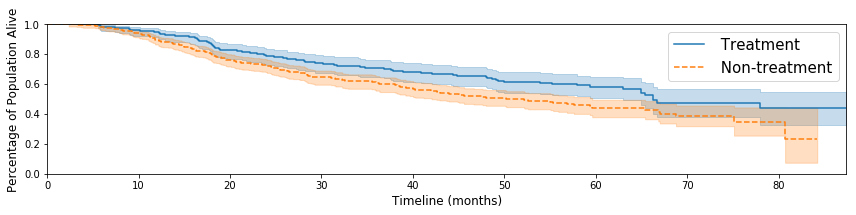

In [11]:
#trt recommandation
treatment_idx = 0
results_dir = 'C:/Users/ASUS/Dropbox/석사학위논문/model_path'

if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/gbsg_cancer_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }
    
    if 'test' in datasets and treatment_idx is not None:
        print("Calculating treatment recommendation survival curvs")
        # We use the test dataset because these experiments don't have a viz dataset
        save_treatment_rec_visualizations(model, test_dataset, output_dir=results_dir, 
            trt_idx = treatment_idx)

# SUPPORT

In [12]:
hyperparams = {"learning_rate": 0.03279227024343838, 
               "dropout": 0.1982763671875, 
               "lr_decay": 0.000645986328125, 
               "momentum": 0.9450444335937499, 
               "L2_reg": 3.54434228515625, 
               "batch_norm": False, 
               "standardize": True, 
               "n_in": 14, 
               "hidden_layers_sizes": [33, 33, 33], 
               "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/support_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = deep_surv.DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 1200,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.6600248896950646}
Test metrics: {'c_index': 0.616673579488198, 'c_index_bootstrap': {'mean': 0.6180321750460265, 'confidence_interval': (0.6162545741943971, 0.6198097758976558)}}


# METABRIC

In [10]:
hyperparams ={"learning_rate": 0.0020065103592061526, 
              "dropout": 0.034404296875000004, 
              "lr_decay": 0.00055220703125, 
              "momentum": 0.8109013671875, 
              "L2_reg": 4.6593974609375,
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 9, 
              "hidden_layers_sizes": [42, 42, 42], 
              "activation": "selu"}

if __name__ == '__main__':

    # Load Dataset
    datasets = utils.load_datasets('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/metabric_IHC4_clinical_train_test.h5')
    norm_vals = {
            'mean' : datasets['train']['x'].mean(axis =0),
            'std'  : datasets['train']['x'].std(axis=0)
        }

    # Train Model
    
    model = deep_surv.DeepSurv(**hyperparams)
    if 'valid' in datasets:
        valid_data = datasets['valid']
    else:
        valid_data = None
        metrics = model.train(datasets['train'], valid_data, n_epochs = 1200,
        update_fn = utils.get_optimizer_from_str('adam'),
        validation_frequency = 100)

    # Evaluate Model

    train_data = datasets['train']
    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if 'valid' in datasets:
        valid_data = datasets['valid']
        if hyperparams['standardize']:
            valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
            metrics = evaluate_model(model, valid_data)
        print("Valid metrics: " + str(metrics))

    if 'test' in datasets:
        test_dataset = utils.standardize_dataset(datasets['test'], norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, test_dataset, bootstrap=True)
        print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.7143060294032179}
Test metrics: {'c_index': 0.6351767943227195, 'c_index_bootstrap': {'mean': 0.6312746107538216, 'confidence_interval': (0.6275111783629457, 0.6350380431446976)}}


# NWTOCO

In [74]:
#nwtco 데이터 불러오기
nwtco = pd.read_csv('C:/Users/ASUS/Dropbox/석사학위논문/DeepSurv-master/data/nwtco.csv')
train_df = nwtco.drop('seqno', axis = 1)
train_df = train_df.rename(columns = {'rel':'Event', 'edrel':'Time'})

#censored number
c_number = train_df['Event'].value_counts()[0]
feat_num = len(list(train_df.columns))
total_number = len(train_df['Event'])
c_rate = (c_number / total_number) * 100

print("total_number : ", total_number)
print("feature_number : ", feat_num)
print("censored_number : ", c_number)
print("censored_rate : " , c_rate)

#data split
train_df, test_df = train_test_split(train_df, test_size = 0.2)
train_df, val_df = train_test_split(train_df, test_size = 0.2)

# event_col is the header in the df that represents the 'Event / Status' indicator
# time_col is the header in the df that represents the event time
def dataframe_to_deepsurv_ds(df, event_col = 'Event', time_col = 'Time'):
    # Extract the event and time columns as numpy arrays
    e = df[event_col].values.astype(np.int32)
    t = df[time_col].values.astype(np.float32)

    # Extract the patient's covariates as a numpy array
    x_df = df.drop([event_col, time_col], axis = 1)
    x = x_df.values.astype(np.float32)
    
    # Return the deep surv dataframe
    return {
        'x' : x,
        'e' : e,
        't' : t
    }

# If the headers of the csv change, you can replace the values of 
# 'event_col' and 'time_col' with the names of the new headers
# You can also use this function on your training dataset, validation dataset, and testing dataset
train_data = dataframe_to_deepsurv_ds(train_df, event_col = 'Event', time_col= 'Time')
val_data = dataframe_to_deepsurv_ds(val_df, event_col = 'Event', time_col = 'Time')
test_data = dataframe_to_deepsurv_ds(test_df, event_col = 'Event', time_col = 'Time')

total_number :  4028
feature_number :  8
censored_number :  3457
censored_rate :  85.82423038728898


In [57]:
#Hyperparameter tunning
def get_optimizer_from_str(update_fn):
    if update_fn == 'sgd':
        return lasagne.updates.sgd
    elif update_fn == 'adam':
        return lasagne.updates.adam
    elif update_fn == 'rmsprop':
        return lasagne.updates.rmsprop

    return None

def get_objective_function(num_epochs):

    def format_to_deepsurv(x, y):
        return {
            'x': x,
            'e': y[:,0].astype(np.int32),
            't': y[:,1].astype(np.float32)
        }

    def get_hyperparams(params):
        hyperparams = {
            'batch_norm': False,
            'activation': 'selu',
            'standardize': True
        }
        # @TODO add default parameters and only take necessary args from params
        # protect from params including some other key

        if 'num_layers' in params and 'num_nodes' in params:
            params['hidden_layers_sizes'] = [int(params['num_nodes'])] * int(params['num_layers'])
            del params['num_layers']
            del params['num_nodes']


        hyperparams.update(params)
        return hyperparams

    def train_deepsurv(x_train, y_train, x_test, y_test,
        **kwargs):
        # Standardize the datasets
        train_mean = x_train.mean(axis = 0)
        train_std = x_train.std(axis = 0)

        x_train = (x_train - train_mean) / train_std
        x_test = (x_test - train_mean) / train_std

        train_data = format_to_deepsurv(x_train, y_train)
        valid_data = format_to_deepsurv(x_test, y_test)

        hyperparams = get_hyperparams(kwargs)

        network = deep_surv.DeepSurv(n_in=x_train.shape[1], **hyperparams)
        metrics = network.train(train_data, n_epochs = num_epochs,
            update_fn = lasagne.updates.nesterov_momentum, verbose = False)

        result = network.get_concordance_index(**valid_data)
        return result

    return train_deepsurv



if __name__ == '__main__':

    NUM_EPOCHS = 500
    NUM_FOLDS = 3

    x = train_data['x']
    e = train_data['e']
    
    t = train_data['t']
    y = np.column_stack((e, t))
    
    

    opt_fxn = get_objective_function(NUM_EPOCHS)
    opt_fxn = optunity.cross_validated(x=x, y=y, num_folds=NUM_FOLDS,
        strata=False)(opt_fxn)

    opt_params, _, _ = optunity.maximize(opt_fxn, num_evals=200,
        learning_rate =[0.000001,0.001], 
        lr_decay = [0.0001, 0.001], 
        momentum = [0.8, 0.95],
        L2_reg = [2.0, 7.0], 
        dropout = [0.01, 0.7],
        num_layers = [1,3],
        num_nodes = [20,45])

In [58]:
opt_params

{'learning_rate': 0.0005151337890625001,
 'lr_decay': 0.00062470703125,
 'momentum': 0.812744140625,
 'L2_reg': 3.7138671875,
 'dropout': 0.059189453125,
 'num_layers': 2.212890625,
 'num_nodes': 26.3232421875}

In [5]:
opt_params

{'learning_rate': -4.076415054095613,
 'lr_decay': 0.0006685098858101879,
 'momentum': 0.8819902343749998,
 'L2_reg': 4.7448492866103535,
 'dropout': 0.4537046180190415}

In [78]:
hyperparams ={"learning_rate": 0.0005151337890625001, 
              "dropout": 0.059189453125, 
              "lr_decay": 0.00062470703125, 
              "momentum": 0.812744140625, 
              "L2_reg": 3.7138671875,
              "batch_norm": False, 
              "standardize": True, 
              "n_in": 6, 
              "hidden_layers_sizes": [26,26], 
              "activation": "selu"}

if __name__ == '__main__':

    # Load Dataset
    norm_vals = {
            'mean' : train_data['x'].mean(axis =0),
            'std'  : train_data['x'].std(axis=0)
        }

    # Train Model
    
    model = deep_surv.DeepSurv(**hyperparams)
    
    valid_data = None
    metrics = model.train(train_data, valid_data, n_epochs = 1200,
    update_fn = utils.get_optimizer_from_str('adam'),
    validation_frequency = 100)

    # Evaluate Model

    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))

    test_dataset = utils.standardize_dataset(test_data, norm_vals['mean'], norm_vals['std'])
    metrics = evaluate_model(model, test_dataset, bootstrap=True)
    print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.7048686919094255}
Test metrics: {'c_index': 0.7423415789290398, 'c_index_bootstrap': {'mean': 0.7419811133701564, 'confidence_interval': (0.737154837909221, 0.7468073888310918)}}


# non-linear dist(gaussian)

In [5]:
#generate data
def generate_data(treatment_group = False):
    np.random.seed(123)
    sd = deepsurv.datasets.SimulatedData(5, num_features = 15,
        treatment_group = treatment_group)
    train_data = sd.generate_data(2000,method = 'gaussian')
    valid_data = sd.generate_data(600,method = 'gaussian')
    test_data = sd.generate_data(600,method = 'gaussian')

    return train_data, valid_data, test_data

train_data, valid_data, test_data = generate_data()

In [82]:
hyperparams ={"learning_rate": 0.001485675043584323, 
              "dropout": 0.0735595703125, 
              "lr_decay": 0.00024959960937500004, 
               "momentum": 0.93199267578125, 
              "L2_reg": 2.78821044921875, 
              "batch_norm": False, 
              "standardize": False, 
              "n_in": 9,
              "hidden_layers_sizes": [39, 39, 39],
              "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    norm_vals = {
            'mean' : train_data['x'].mean(axis =0),
            'std'  : train_data['x'].std(axis=0)
        }

    # Train Model
    
    model = deep_surv.DeepSurv(**hyperparams)

    metrics = model.train(train_data, valid_data, n_epochs = 1000,
    update_fn = utils.get_optimizer_from_str('adam'),
    validation_frequency = 100)

    # Evaluate Model

    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if hyperparams['standardize']:
        valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, valid_data)
    print("Valid metrics: " + str(metrics))

    test_dataset = utils.standardize_dataset(test_data, norm_vals['mean'], norm_vals['std'])
    metrics = evaluate_model(model, test_dataset, bootstrap=True)
    print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.6169505582892015}
Valid metrics: {'c_index': 0.6169505582892015}
Test metrics: {'c_index': 0.6053940918261971, 'c_index_bootstrap': {'mean': 0.6043976354075384, 'confidence_interval': (0.6029620186977578, 0.6058332521173191)}}


In [15]:
hyperparams ={"learning_rate": 0.001485675043584323, 
              "dropout": 0.0735595703125, 
              "lr_decay": 0.00024959960937500004, 
               "momentum": 0.93199267578125, 
              "L2_reg": 2.78821044921875, 
              "batch_norm": False, 
              "standardize": False, 
              "n_in": 15,
              "hidden_layers_sizes": [39, 39, 39],
              "activation": "selu"}


if __name__ == '__main__':

    # Load Dataset
    norm_vals = {
            'mean' : train_data['x'].mean(axis =0),
            'std'  : train_data['x'].std(axis=0)
        }

    # Train Model
    
    model = deep_surv.DeepSurv(**hyperparams)

    metrics = model.train(train_data, valid_data, n_epochs = 700,
    update_fn = utils.get_optimizer_from_str('adam'),
    validation_frequency = 100)

    # Evaluate Model

    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if hyperparams['standardize']:
        valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, valid_data)
    print("Valid metrics: " + str(metrics))

    test_dataset = utils.standardize_dataset(test_data, norm_vals['mean'], norm_vals['std'])
    metrics = evaluate_model(model, test_dataset, bootstrap=True)
    print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.5919729632966998}
Valid metrics: {'c_index': 0.5919729632966998}
Test metrics: {'c_index': 0.5681025097010134, 'c_index_bootstrap': {'mean': 0.5673261755117299, 'confidence_interval': (0.5647132521582097, 0.5699390988652502)}}


# linear

In [16]:
def generate_data(treatment_group = False):
    np.random.seed(123)
    sd = deepsurv.datasets.SimulatedData(5, num_features = 15,
        treatment_group = treatment_group)
    train_data = sd.generate_data(2000,method = 'linear')
    valid_data = sd.generate_data(600,method = 'linear')
    test_data = sd.generate_data(600,method = 'linear')

    return train_data, valid_data, test_data

train_data, valid_data, test_data = generate_data()

In [18]:
hyperparams ={"L2_reg": 3.95590771484375, 
              "dropout": 0.1373681640625, 
              "learning_rate": 0.0005748708832034106, 
              "lr_decay": 0.00022252929687500002, 
              "momentum": 0.8525219726562501, 
              "batch_norm": True, 
              "standardize": True, 
              "n_in": 15, 
              "hidden_layers_sizes": [14, 14]}



if __name__ == '__main__':

    # Load Dataset
    norm_vals = {
            'mean' : train_data['x'].mean(axis =0),
            'std'  : train_data['x'].std(axis=0)
        }

    # Train Model
    
    model = deep_surv.DeepSurv(**hyperparams)

    metrics = model.train(train_data, valid_data, n_epochs = 1000,
    update_fn = utils.get_optimizer_from_str('adam'),
    validation_frequency = 100)

    # Evaluate Model

    if hyperparams['standardize']:
        train_data = utils.standardize_dataset(train_data, norm_vals['mean'], norm_vals['std'])

    metrics = evaluate_model(model, train_data)
    print("Training metrics: " + str(metrics))
    if hyperparams['standardize']:
        valid_data = utils.standardize_dataset(valid_data, norm_vals['mean'], norm_vals['std'])
        metrics = evaluate_model(model, valid_data)
    print("Valid metrics: " + str(metrics))

    test_dataset = utils.standardize_dataset(test_data, norm_vals['mean'], norm_vals['std'])
    metrics = evaluate_model(model, test_dataset, bootstrap=True)
    print("Test metrics: " + str(metrics))

Training metrics: {'c_index': 0.7761861148625923}
Valid metrics: {'c_index': 0.7619753793300887}
Test metrics: {'c_index': 0.7680248252312946, 'c_index_bootstrap': {'mean': 0.7694546272308146, 'confidence_interval': (0.7675427103594148, 0.7713665441022144)}}
